# Contents
This tutorial is dedicated to the analysis of sea-ice concetration data from space. In the following you will learn how
* to compute climatologies from NetCDF data
* to visualize maps of sea-ice concetration
* to compute the sea-ice extent and display its seasonal cycle
* to select sub-regions and compare their sea-ice extent seasonal cycles

# Sea ice concentration dataset from satellite passive microwave
There are several products with satellite-derived sea ice concentration. They vary in the type of sensor on the satellite payload and the algorithm used to process the data. 

We will use one of the first product from NASA, based on the NASA Team algorithm and data from a variety of sensors on multiple satellites. This product has been freely available since 1996 and it is fully described here: https://nsidc.org/data/nsidc-0051 

When using the data, remember to make reference with the proper citation:

>*Cavalieri, D. J., C. L. Parkinson, P. Gloersen, and H. J. Zwally. 1996, updated yearly. Sea Ice Concentrations from Nimbus-7 SMMR and DMSP SSM/I-SSMIS Passive Microwave Data, Version 1. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/8GQ8LZQVL0VL.*

This dataset contains daily sea ice concentration from 1979 to the present. However, since the file is more than 5 GB, we will use a processed version that contains the climatology for the period 1979-2005 (more on climatologies in the next section). The file for the monthly and daily climatologies are available on the course website in NetCDF format:
- NSIDC_0051_SIC_1979-2005_dclim.nc (daily climatology)
- NSIDC_0051_SIC_1979-2005_mclim.nc (monthly climatology)

The following code analyses the monthly data. Repeat this analysis with the daily climatology as an exercise.

## How to process NetCDF data (theory)

Gridded data in Earth Sciences are distributed using the [NetCDF format](https://www.unidata.ucar.edu/software/netcdf/). Most of the scientific visualization softwares implement dedicated libraries to load and work with this format. [xarray](http://xarray.pydata.org/en/stable/) is the python library that we will use in this tutorial.
However, performing multiple batch operations such concatenation and averaging is a lenghty process that is better suited for dedicated software. [cdo](https://code.mpimet.mpg.de/projects/cdo) and [nco](https://code.mpimet.mpg.de/projects/cdo) are two of these tools. They are better suited for the linux environment, but can also be run from mac OS and windows.

To learn more about `cdo`, follow the [cdo Tutorial](https://code.mpimet.mpg.de/projects/cdo/wiki/Tutorial).

### Time averages and climatologies

The majority of publicly available gridded data are provided in separate files, each one containing a given number of records (3-hourly, daily, monthly, etc). 
The number of records is included in the record dimension, which is described by a corresponding variable, called a coordinate variable. There is no specific convention for names, but it is customary to use the same name for the record dimension and for the coordinate variable.
In the following example, <code style="color:#008000">time</code> is the name of the record dimension and of the coordinate variable. It should be interpreted as "the variable `time` has dimension <code style="color:#008000">time</code> and contains 12 records". 
```sh
dimensions:
	time = UNLIMITED ; // (12 currently)
variables:
	double time(time) ;
		time:standard_name = "time" ;
		time:long_name = "ANSI date" ;
		time:units = "days since 1601-01-01 00:00:00" ;
		time:calendar = "gregorian" ;
		time:axis = "T" ;
```
The value contained in a given record (or index) of the variable `time` identifies the time stamp that follows a convention. The attributes units and calendar are used to identify the convention and needs to be preserved to ensure that the metadata are consistent with the content.


### Temporal concatenation of gridded files

A climatology is the average of records over a certain time period (in climate sciences, one needs at least 30 years to define a climatology, however the term is used in a more general sense). There are different types of climatologies; the most often used are the following:
- annual (overall) long-term mean. This is the average of all the records in the dataset
- monthly or seasonal climatological means. The records are grouped according to the months or the seasons and then averaged over the years in the data set. Seasons are usually calendar seasons (DJF, MAM, JJA, SON), but it may vary depending on the context, so it is always important to specify the choice. Because the number of days in each month or season are (almost...) fixed, there is no difference if you first compute the monthly means and then the climatology for each month by averaging them over the years.
- daily climatological means. 

When computing temporal averages, one needs to decide what will be the resulting reference date. For instance, a monthly average may be centred on the first day or at the middle of the month. There is no fixed convention, and you should check the default in the software you use, and whether you can change it if needed. `cdo` uses the end of the interval, hence the January mean is located on the 31st of January.

Before computing climatologies, it is often necessary to concatenate or merge the various records. This operation is not very efficient, because the original data must be replicated and during the processing the disk occupation may often triplicate.
If you have extra disk space available on an external drive, it may be good to store the original data. If not, it is advisable to delete them. 
You can always split your concatenated file and revert back to the original files. 
>*Note that the history attribute in the netcdf file usually keeps track of the sequence of operations you made, which is a good thing! Don't delete the history attribute!*

Concatenating files with `cdo` is simple
```sh
cdo -mergetime {filelist} concatenated_output.nc
```
`{filelist}` can be a list of files or a filename with wildcards, like `*.nc`. 
This operation is however possible only if your time dimension is UNLIMITED, which means it is defined as a NetCDF record dimension. 
Your file may still have a time dimension but not necessarily an expandable record dimension. This is often the case with remote sensing products or other data sets.
In order to concatenate along the record dimension you first need to create a time dimension that is expandable, which means it needs to have the `UNLIMITED` flag. This cannot be done with `cdo`, and you need to use `nco` the other Swiss knife of NetCDF operations, and more specifically the tool `ncks` (netcdf "kitchen sink"). The rationale is to convert the time dimension to a record dimension only in the first file, and then to concatenate all the other files to this new one.
```sh
ncks -O --mk_rec_dmn {time_dimension_name} first_in.nc first_out.nc
ncrcat -h first_out.nc {other_files} concatenated_output.nc
```

### Computing monthly means and climatologies

Let's assume our file `concatenated_output.nc` contains a time series of sea-ice concentration daily data from 1979 to 2019, in a file called `seaice_conc_daily_sh_1978_2019.nc`. It is imperative to give sensible names to your files. Remember that `cdo` will record your operation in the history attribute, but it will not change units or names of the variables. This is an important postprocessing operation that you should always remember to do to preserve the metadata.

The following commands create the monthly mean using the `cdo` operator `monmean` and the monthly climatology using `ymonmean`:
```sh
cdo monmean seaice_conc_daily_sh_1978_2019.nc seaice_conc_mon_sh_1978_2019.nc
cdo ymonmean seaice_conc_mon_sh_1978_2019.nc seaice_conc_monclim_sh_1978_2019.nc
```

If you do not need to store the monthly means, `cdo` allows to compute directly the monthly climatology
```sh
cdo ymonmean seaice_conc_daily_sh_1978_2019.nc seaice_conc_monclim_sh_1978_2019.nc
```

The storage of the monthly mean is often useful, in case you want to compute the climatological monthly anomaly, which is the difference between each month in the time series and the climatological mean for that month (the difference between January 1999 and the mean of all the Januaries): 
```sh
cdo ymonsub seaice_conc_mon_sh_1978_2019.nc seaice_conc_monclim_sh_1978_2019.nc seaice_conc_monanom_sh_1978_2019.nc
```
Notice that in this case you need two input streams, the two operands of the subtraction, and one output stream, the result of the operation.

## Analysis of monthly climatological sea-ice concentration data

In [1]:
# import the required modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean # using this through the "cmo" variable, so must be imported
import cartopy.crs as ccrs

In [2]:
import calendar
# get the months name
months = calendar.month_name[1:]

In [3]:
DATADIR='/mnt/c/Users/marce/Documents/WORKS/PROJECTS/ONGOING/SASUF-HighSeas/practical/'
ds = xr.open_dataset(DATADIR+'NSIDC_0051_SIC_1979-2005_mclim.nc')

Good practice is to always check the metadata, to find out the names of the variables and other information:

In [4]:
ds

<xarray.Dataset>
Dimensions:                                   (longitude: 1440, latitude: 203, time: 12)
Coordinates:
  * longitude                                 (longitude) float32 -179.9 ... ...
  * latitude                                  (latitude) float32 -39.36 ... -...
  * time                                      (time) datetime64[ns] 2004-01-3...
Data variables:
    Sea_Ice_Concentration_with_Final_Version  (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.2 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Thu Sep 15 11:00:40 2016: cdo ymonmean -selyear,1979/2005 N...
    source:       See the title and references for this information
    institution:  National Snow & Ice Data Center, Boulder, CO
    title:        Sea Ice Concentrations from Nimbus-7 SMMR and DMSP SSM/I-SS...
    comment:      Not set at this time
    references:   Documentation available at: http://nsidc.org/data/nsidc-005...
    CDO:          Climate Data Operators version 1.6.2 (http://code.zmaw.de/p...

From the history, we can find out the post-processing done on the data. GDAL is a translator library for raster and vector geospatial data formats, which has been used to transform the data from the original stereographic polar coordinate reference system (CRS) to a geographical CRS.

We will now check the content of the Data Variable (there is only one in this file).

In [5]:
field = ds.Sea_Ice_Concentration_with_Final_Version
field

<xarray.DataArray 'Sea_Ice_Concentration_with_Final_Version' (time: 12, latitude: 203, longitude: 1440)>
[3507840 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -39.36 -39.61 -39.86 ... -89.36 -89.61 -89.86
  * time       (time) datetime64[ns] 2004-01-31T07:00:00 ... 2004-12-31T07:00:00
Attributes:
    long_name:  Sea Ice Concentration, Final Version
    units:      %
    datum:      +ellps=WGS84

We notice that some values are larger than the maximum expected percentage (100%). It is not written anywhere in the metadata, but in the documentation you will find that 
> *Data are stored as one-byte integers representing sea ice concentration values. The sea ice
concentration data are packed into byte format by multiplying the derived fractional sea ice
concentration floating-point values (ranging from 0.0 to 1.0) by a scaling factor of 250. For
example, a sea ice concentration value of 0.0 (0%) maps to a stored one-byte integer value of 0,
and a sea ice concentration value of 1.0 (100%) maps to a stored one-byte integer value of 250. To
convert to the fractional parameter range of 0.0 to 1.0, divide the scaled data in the file by 250. To
convert to percentage values (0% to 100%), divide the scaled data in the file by 2.5.*

Antarctic grid points are indicated with the flag 254. This can be checked and eventually fixed by extracting only the valid points. All the others will be masked with `np.nan`. The same can be done if you want to exclude the ocean points.

In [6]:
print([np.min(field),np.max(field)])

[<xarray.DataArray 'Sea_Ice_Concentration_with_Final_Version' ()>
array(0.), <xarray.DataArray 'Sea_Ice_Concentration_with_Final_Version' ()>
array(254.)]


In [7]:
field = field.where(field<=250.)/2.5
field

<xarray.DataArray 'Sea_Ice_Concentration_with_Final_Version' (time: 12, latitude: 203, longitude: 1440)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -39.36 -39.61 -39.86 ... -89.36 -89.61 -89.86
  * time       (time) datetime64[ns] 2004-01-31T07:00:00 ... 2004-12-31T07:00:00

## Climatological maps
We can now take advantage of the multi-faceting facility offered by xarray http://xarray.pydata.org/en/stable/user-guide/plotting.html to visualize all the 12 months in the file and look at the seasonal cycle. This will be done using the mapping tool [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

/home/vichi/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


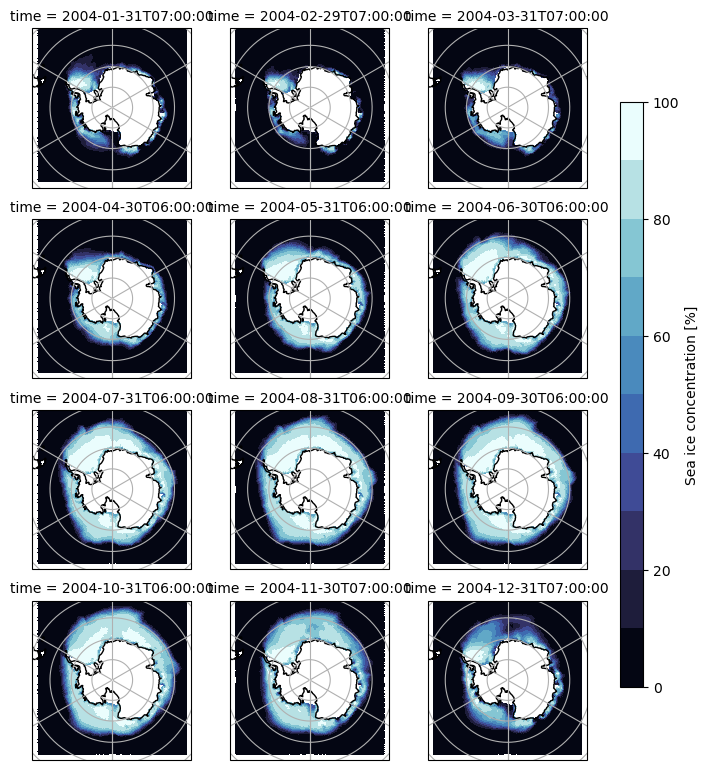

In [8]:
data_crs = ccrs.PlateCarree()
map_proj = ccrs.SouthPolarStereo()

# the following line creates a discrete colormap with 10 colors (intervals of 10%)
cmap=plt.cm.get_cmap('cmo.ice', 10)
p = field.plot(figsize=(8.5,9.5), # sets the figure dimension
               transform=data_crs,  # the data's projection
               col='time', col_wrap=3,  # multiplot settings
               aspect=len(field.longitude) / len(field.latitude),  # for a sensible figsize
               cmap=cmap, vmin=0, vmax=100, # colormap and ranges
               subplot_kws={'projection': map_proj}, # keywords for the projection
               cbar_kwargs={'shrink':0.8,'pad':0.05,'fraction':0.1,'aspect':25, # keywords for the colorbar
                'label': 'Sea ice concentration [%]'})
# add a few annotations
for i,ax in enumerate(p.axes.flat):
    ax.gridlines()
    ax.coastlines()
    ax.set_extent([-180, 180, -90, -52], ccrs.PlateCarree())
    #ax.set_title(months[i])

plt.show()

## Seasonal cycle of sea ice extent

We want to plot the seasonal cycle of the SIC and sie ice extent (SIE) for a region of choice. SIE is defined as the total area of the cells where SIC is greater than 15%. 

### Antarctic SIE 
We need to convert the SIC (which is an area fraction) into the actual area. If the concentration is lower than 15%, the area is zero; if it's greater, it is assumed that the cell is fully covered. 
The actual area (SIA) comes from the product between SIC and the area.

We will compute the climatological seasonal cycle of SIE for the entire Antarctic sea ice. You can compute the SIA as an exercise and compare the two.
This will be done using `numpy` operations, so we first need to extract the data as a numpy array:

In [9]:
ice = field.data/100. # extract concentration values as a numpy array and convert to a fraction
print(type(ice))
print(ice.shape)

<class 'numpy.ndarray'>
(12, 203, 1440)


which is a 3D array with dimensions time, latitude and longitude. The SIE is computed by first creating an array of sea-ice presence/absence, discretizing the concentration values according to the thresholds. Let's have a quick look at the resulting first time record (January)

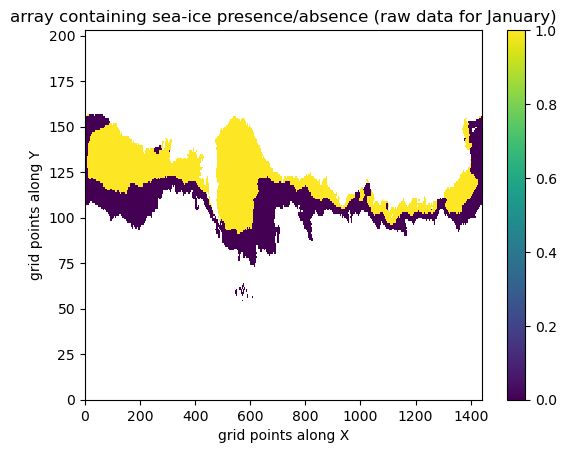

In [10]:
ice[ice==0]=np.nan
ice[ice<0.15] = 0.; ice[ice>=0.15] = 1. # assign presence/absence
im = plt.pcolormesh(ice[0,:,:])
plt.colorbar(im)
plt.title('array containing sea-ice presence/absence (raw data for January)')
plt.xlabel('grid points along X')
plt.ylabel('grid points along Y')
plt.show()

>*Notice that the cartesian representation of a matrix is upside down!*

To compute the SIE we need to know the area of each grid cell and then add them up. The array coordinates are geographical and we can check the size of each cell in the following way:

In [11]:
dlat = np.diff(ds.latitude.data)
dlon = np.diff(ds.longitude.data)
print(dlat)
print(dlon)

[-0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0

The cells are regular in the geographic CRS, 0.25 x 0.25 degrees. However, the length in km of one degree latitude is constant, while the length of one degree longitude depends on the latitude. The following code compute the area as an array with the same dimension as the input data. This array will be used to compute the total area.

In [12]:
[lon,lat] = np.meshgrid(ds.longitude,ds.latitude)
degree_lat_in_km = 2.*np.pi*6371./360.
area = (0.25 * degree_lat_in_km)**2 * np.cos(np.pi*lat/180.)

The SIE is the sum of all the cell areas. Note how convenient `numpy` is in broadcasting the array for an efficient computation computation. `sip` and `area` have different shapes, but the software understands how to broadcast a 2D array into a 3D array

In [13]:
sie = np.nansum(ice*area,axis=(1,2))
print(sie.shape)

(12,)


The result is an array with 12 values. Note how the sum is done on the spatial dimensions (the 2nd and 3rd). We can now plot the monthly timeseries. *Note that we tile the same array twice to see the full seasonal cycle and the transitional periods between winter and summer*

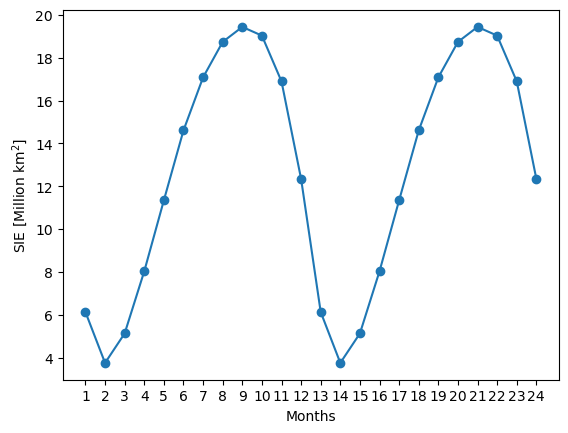

In [14]:
plt.plot(range(1,25),np.tile(sie/1.e6,2),'-o')
plt.xticks(range(1,25))
plt.xlabel('Months')
plt.ylabel('SIE [Million km$^2$]')
plt.show()

### Regional SIE
Antarctic sea ice has been divided in several sectors. We will use the ones defined by Raphael and Hobbs (2014, https://doi.org/10.1002/2014GL060365)
Since the data are on a regular grid, it is relatively straightforward to compute averages over a region identified by longitudinal limits. We define first the boundaries, extract the portion of the array using the `where` function and then compute the diagnostics over the regions as done for the whole Antarctic.

In [15]:
#%% Region definitions
KH = [-15,70]   # King Hakon VII
WS = [-60,-15]  # Weddell Sea
EA = [60,170]   # East Antarctica
AB = [-110,-60] # Amundsen/Bellingshausen Seas
RS = [170,-110] # Ross Sea
regions = [RS,AB,WS,KH,EA]
region_names = ['Ross Sea',
             'Amundsen/Bellingshausen Seas',
             'Weddell Sea',
             'King Haakon VII',
             'East Antarctica']

# define the array holding the monthly SIE for each region
sie_regions = np.zeros([len(regions),12])

for r,reg in enumerate(regions): 
    if r==0: # for Ross Sea region we need to take into account the dateline
        condition = ((ds['longitude'] >= reg[0]) | (ds['longitude'] < reg[1]))
    else:
        condition = ((ds['longitude'] >= reg[0]) & (ds['longitude'] < reg[1]))
    sel_ice = np.where(condition, ice, 0.) # extract the data in the selected region (numpy where)
    sel_area = np.where(condition,area,0.) # do the same for the area (numpy where)
#    sip = field.data # extract conc values
#    sip[sip<0.15] = 0.; sip[sip>=0.15] = 1. # assign presence/absence
    sie_regions[r,:] = np.nansum(sel_ice*sel_area,axis=(1,2)) # compute sea ice extent


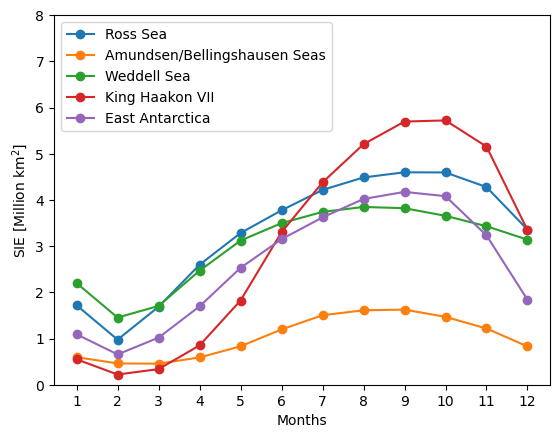

In [16]:
plt.plot(range(1,13),sie_regions.T/1.e6,'-o')
plt.legend(region_names)
plt.ylim(0,8)
plt.xticks(range(1,13))
plt.xlabel('Months')
plt.ylabel('SIE [Million km$^2$]')
plt.show()

We notice the different seasonal cycles, which highlight contrasting regions in Antarctic sea ice. All cycles are asymmetric, but the majro difference is observed in the Atlantic sector, between the eastern and western Weddell Sea.